# A Seq2Seq Model with Attention Module

## 0. Load modules

In [1]:
import io
import json
import numpy as np
import os
import random
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
home_dir = os.path.expanduser('~')

sys.path.append(home_dir + '/Qurator/mono-repo/sbb_ocr_correction/qurator/sbb_ocr_correction/data_preproc/dta')
from database import load_alignments_from_sqlite
sys.path.append(home_dir + '/Qurator/mono-repo/sbb_ocr_correction/qurator/sbb_ocr_correction/mt/preproc')
from data import OCRCorrectionDataset
sys.path.append(home_dir + '/Qurator/mono-repo/sbb_ocr_correction/qurator/sbb_ocr_correction/mt/feature_extraction')
from encoding import decode_sequence

## 1. Load and preprocess data

In [2]:
# path definitions
alignments_path = home_dir + '/Qurator/used_data/preproc_data/dta/aligned_corpus.db'
ocr_encodings_path = home_dir + '/Qurator/used_data/features/dta/encoded_ocr_padded.npy'
gt_encodings_path = home_dir + '/Qurator/used_data/features/dta/encoded_gt_padded.npy'
token_to_code_path = home_dir + '/Qurator/used_data/features/dta/token_to_code_mapping.json'
code_to_token_path = home_dir + '/Qurator/used_data/features/dta/code_to_token_mapping.json'

In [3]:
ocr_encodings = np.load(ocr_encodings_path, allow_pickle=True)
gt_encodings = np.load(gt_encodings_path, allow_pickle=True)

with io.open(token_to_code_path, mode='r') as f_in:
    token_to_code_mapping = json.load(f_in)
with io.open(code_to_token_path, mode='r') as f_in:
    code_to_token_mapping = json.load(f_in)

alignments, alignments_as_df, alignments_headers = load_alignments_from_sqlite(alignments_path, size='total')

In [4]:
len(alignments)

121853

In [5]:
assert ocr_encodings.shape == gt_encodings.shape

In [6]:
print('OCR encoding dimensions {}'.format(ocr_encodings.shape))
print('GT encoding dimensions {}'.format(gt_encodings.shape))

OCR encoding dimensions (121853, 54)
GT encoding dimensions (121853, 54)


In [7]:
dataset_total = OCRCorrectionDataset(ocr_encodings, gt_encodings)
data_subset = OCRCorrectionDataset(ocr_encodings[0:50], gt_encodings[0:50])

In [8]:
encoding_size = len(token_to_code_mapping) + 1 # add 1 for additional 0 padding, i.e. padded 0 are treated as vocab
print(encoding_size)

21765


## 2. Encoder-Decoder-Attention

In [9]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size, num_layers=1, dropout=0, device='cpu'):
        super(EncoderLSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.cell_size = hidden_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.device = device
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        
    def forward(self, x, hidden, cell):
        
        embedded = self.embedding(x).view(self.batch_size, 1, -1)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        
        return output, hidden, cell
    
    def init_hidden_state(self):
        return torch.zeros(1, self.batch_size, self.hidden_size, device=self.device)
    
    def init_cell_state(self):
        return torch.zeros(1, self.batch_size, self.cell_size, device=self.device)

In [10]:
class EncoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size, num_layers=1, dropout=0, device='cpu'):
        super(EncoderGRU, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.device = device
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, x, hidden):
        embedded = self.embedding(x).view(self.batch_size, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def init_hidden_state(self):
        return torch.zeros(1, self.batch_size, self.hidden_size, device=self.device)

In [11]:
class DecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size, batch_size, num_layers=1, dropout=0, device='cpu'):
        super(DecoderLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.cell_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.device = device
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        #self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, hidden, cell):
        
        output = self.embedding(x).view(self.batch_size, 1, -1)
        output = F.relu(output)
        output, (hidden, cell) = self.lstm(output, (hidden, cell))
        
        output = self.fc(output).view(self.batch_size, -1)
        output = F.log_softmax(output, dim=1)
        
        #output = self.softmax(self.fc(output)).view(self.batch_size, -1)
        return output, hidden, cell
    
    def init_hidden_state(self):
        return torch.zeros(1, self.batch_size, self.hidden_size, device=self.device)
    
    def init_cell_state(self):
        return torch.zeros(1, self.batch_size, self.hidden_size, device=self.device)

In [12]:
class DecoderGRU(nn.Module):
    def __init__(self, hidden_size, output_size, batch_size, device='cpu'):
        super(DecoderGRU, self).__init__()
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.device = device

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
        output = self.embedding(x).view(self.batch_size, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def init_hidden_state(self):
        return torch.zeros(1, self.batch_size, self.hidden_size, device=self.device)

In [13]:
class AttnDecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size, batch_size, seq_length, num_layers=1, dropout=0, device='cpu'):
        super(AttnDecoderLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.cell_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.dropout = dropout
        self.device = device
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.seq_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, num_layers=num_layers, dropout=self.dropout)
        self.out = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, x, hidden, cell, encoder_outputs):
        embedded = self.embedding(x).view(self.batch_size, 1, -1)
        embedded = F.dropout(embedded, p=self.dropout)
        
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        
        output = F.relu(output)
        output, (hidden, cell) = self.lstm(output, (hidden, cell))
        
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, cell, attn_weights
        
        
    def init_hidden_state(self):
        return torch.zeros(1, self.batch_size, self.hidden_size, device=self.device)
    
    def init_cell_state(self):
        return torch.zeros(1, self.batch_size, self.cell_state, device=self.device)

## 3. Training Code

In [14]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, with_attention, teacher_forcing_ratio, device):
    
    ###################
    #                 #
    #  Encoding Step  #
    #                 #
    ###################
    
         
    #import pdb
    #pdb.set_trace()
    
    encoder_hidden = encoder.init_hidden_state()
    encoder_cell = encoder.init_cell_state()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    # This needs to be checked; dimensions may be different
    input_length = input_tensor.shape[0]
    target_length = target_tensor.shape[0]
    
    # This needs to be checked; dimensions may be different
    encoder_outputs = torch.zeros(target_length, encoder.hidden_size, device=device)
    
    loss = 0
    
    for ei in range(input_length):
        
        encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei], encoder_hidden, encoder_cell)
        encoder_outputs[ei] = encoder_output[0,0]
    
    ###################
    #                 #
    #  Decoding Step  #
    #                 #
    ###################
    
    # Create input tensor with SOS encoding
    #decoder_input = torch.tensor([[input_tensor[0]]], device=device)
    
    decoder_input = input_tensor[0].clone().detach()
    
    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell # Is this correct? (Alternative: initialize cell state to 0)
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if with_attention:
        if use_teacher_forcing:
            # Teacher forcing: Feed the target as the next input
            for di in range(target_length):
                decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
                
                loss += criterion(decoder_output, target_tensor[di])
                decoder_input = target_tensor[di] # Teacher forcing
        else:
            for di in range(target_length):
                decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
                
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()
                
                loss += criterion(decoder_output, target_tensor[di])
    else: 
        if use_teacher_forcing:
            # Teacher forcing: Feed the target as the next input
            for di in range(target_length):
                decoder_output, decoder_hidden, decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell)
            
                loss += criterion(decoder_output, target_tensor[di])
                decoder_input = target_tensor[di] # Teacher forcing
        else:
                   
            for di in range(target_length):
            
                decoder_output, decoder_hidden, decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell)
            
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()
            
                loss += criterion(decoder_output, target_tensor[di])
            
                # Change hard coding (EOS token)
                #if decoder_input.item() == 2:
                #    break
    
    ###############################
    #                             #
    #  Backprop and optimization  #
    #                             #
    ############################### 
    
    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length

In [15]:
import time
import math

def sec_to_min(sec):
    m = math.floor(sec / 60)
    sec -= m * 60
    return '{}min {}sec'.format(int(m), int(sec))

def timeSince(since, percent):
    now = time.time()
    elapsed_sec = now - since
    remaining_sec = (elapsed_sec / (percent)) - elapsed_sec
    return '{:s} (- {:s})'.format(sec_to_min(elapsed_sec), sec_to_min(remaining_sec)) 
    

In [23]:
def trainIters(data_train, encoder, decoder, n_epochs, batch_size, learning_rate=0.01, with_attention=False, print_every=1000, plot_every=20, teacher_forcing_ratio=0.5, device='cpu'):
    start = time.time()
    
    plot_losses = []
    print_loss_total = 0 # Reset every print_every
    plot_loss_total = 0 # Reset every plot_every
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    criterion = nn.NLLLoss()
    
    for epoch in range(1, n_epochs + 1):
        for batch in DataLoader(data_train, batch_size=batch_size):
            
            # Tensor dimensions need to be checked
            input_tensor = batch[:, 0, :]
            input_tensor = torch.t(input_tensor)
            target_tensor = batch[:, 1, :]
            target_tensor = torch.t(target_tensor)
            
            loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, with_attention, teacher_forcing_ratio, device)
            
            print_loss_total += loss
            plot_loss_total += loss
            
        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('{:s} ({:d} {:d}%) {:.6f}'.format(timeSince(start, epoch / n_epochs),
                                         epoch, int(epoch / n_epochs * 100), print_loss_avg))
            
        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    showPlot(plot_losses)
    
    return encoder, decoder

In [17]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## 4. Run Training

0min 47sec (- 0min 47sec) (1 50%) 228.105300
1min 38sec (- 0min 0sec) (2 100%) 159.544983


<Figure size 432x288 with 0 Axes>

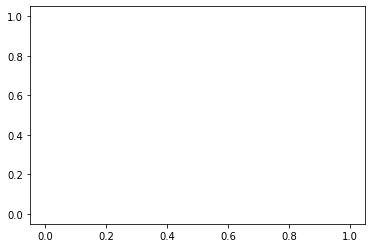

In [39]:
input_size = encoding_size
hidden_size = 256
output_size = input_size
batch_size = 1
n_epochs = 2
learning_rate = 0.001
seq_length = dataset_total[0].shape[-1]
num_layers = 1
dropout = 0.2
with_attention = True
teacher_forcing_ratio = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = EncoderLSTM(input_size, hidden_size, batch_size, num_layers, device=device)#.to(device)

if with_attention:
    decoder = AttnDecoderLSTM(hidden_size, output_size, batch_size, seq_length, num_layers=num_layers, dropout=dropout, device=device)#.to(device)
else:
    decoder = DecoderLSTM(hidden_size, output_size, batch_size, device=device)#.to(device)
    
trained_encoder, trained_decoder = trainIters(data_subset, encoder, decoder, n_epochs=n_epochs, batch_size=batch_size, learning_rate=learning_rate, with_attention=with_attention, plot_every=5, print_every=1, teacher_forcing_ratio=teacher_forcing_ratio, device=device)

## 5. Evaluation Code 

In [36]:
def predict(input_tensor, target_tensor, trained_encoder, trained_decoder, seq_length, with_attention, device):
    with torch.no_grad():
        
        ###################
        #                 #
        #  Encoding Step  #
        #                 #
        ###################
        
        encoder_hidden = trained_encoder.init_hidden_state()
        encoder_cell = trained_encoder.init_cell_state()
        
        encoder_outputs = torch.zeros(seq_length, trained_encoder.hidden_size, device=device)
        
        for ei in range(seq_length):
            encoder_output, encoder_hidden, encoder_cell = trained_encoder(input_tensor[ei], encoder_hidden, encoder_cell)
            encoder_outputs[ei] += encoder_output[0, 0]
        
        ###################
        #                 #
        #  Decoding Step  #
        #                 #
        ###################
        
        #import pdb
        #pdb.set_trace()
        
        decoder_input = input_tensor[0].clone().detach()
        
        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell
        
        decoded_tokens = []
        
        if with_attention:
            decoder_attentions = torch.zeros(seq_length, seq_length)

            for di in range(seq_length):
                decoder_output, decoder_hidden, decoder_cell, decoder_attention = trained_decoder(decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
                
                decoder_attentions[di] = decoder_attention.data
                
                topv, topi = decoder_output.data.topk(1)
                
                decoder_input = topi.squeeze().detach()
                
                decoded_tokens.append(topi.item())
        else:
                    
            for di in range(seq_length):
                decoder_output, decoder_hidden, decoder_cell = trained_decoder(decoder_input, decoder_hidden, decoder_cell)
            
                topv, topi = decoder_output.data.topk(1)
            
                decoder_input = topi.squeeze().detach()
            
                decoded_tokens.append(topi.item())
            
        return decoded_tokens
        
        

In [37]:
def predictIters(data_test, trained_encoder, trained_decoder, batch_size, seq_length, with_attention):
    '''
    
    '''
    decodings = []
    
    #import pdb
    #pdb.set_trace()
    
    for batch in DataLoader(data_test, batch_size=batch_size):
        # Tensor dimensions need to be checked
        input_tensor = batch[:, 0, :]
        input_tensor = torch.t(input_tensor)
        target_tensor = batch[:, 1, :]
        target_tensor = torch.t(target_tensor)
            
        decoded_tokens = predict(input_tensor, target_tensor, trained_encoder, trained_decoder, seq_length, with_attention)
            
        decodings.append(decoded_tokens)
    return decodings 

In [38]:
decodings = predictIters(data_subset, trained_encoder, trained_decoder, batch_size, seq_length, with_attention)

In [33]:
len(decodings)

50

In [34]:
decoded_sequences = []
for decoding in decodings:
    decoded_sequences.append(decode_sequence(decoding, code_to_token_mapping))

In [35]:
decoded_sequences

[['<SOS>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>'],
 ['<SOS>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>',
  '<WSC>'

In [50]:
decodings

[[1,
  1,
  3,
  3271,
  3,
  2,
  3,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [1,
  1,
  3,
  3271,
  3,
  2,
  3,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [1,
  1,
  3,
  3271,
  3,
  0,
  2,
  3,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [1,
  1,
  3,
  3271,
  3,
  0,
  2,
  3,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
